In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from data.clean_churn_data import clean_churn_data
from src.roc import plot_roc_curve
%load_ext autoreload
%autoreload 2

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.metrics import Precision, Recall

In [178]:
churn = pd.read_csv('data/churn_train.csv')
churn = clean_churn_data(churn)
churn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39681 entries, 0 to 39999
Data columns (total 13 columns):
avg_dist                  39681 non-null float64
avg_rating_by_driver      39681 non-null float64
avg_rating_of_driver      39681 non-null float64
avg_surge                 39681 non-null float64
phone                     39681 non-null int64
surge_pct                 39681 non-null float64
trips_in_first_30_days    39681 non-null int64
luxury_car_user           39681 non-null int64
weekday_pct               39681 non-null float64
city: Astapor             39681 non-null int64
city: King's Landing      39681 non-null int64
city: Winterfell          39681 non-null int64
churn?                    39681 non-null int64
dtypes: float64(6), int64(7)
memory usage: 4.2 MB


In [180]:
cols = ['avg_dist','avg_rating_by_driver','avg_rating_of_driver','avg_surge','surge_pct','trips_in_first_30_days','weekday_pct']

for col in cols:
    churn[(col + ' ^2')] = churn[col] ** 2
    churn[(col + ' ^3')] = churn[col] ** 3
    churn[(col + ' exp^')] = np.exp(churn[col])
    churn[(col + ' sin')] = np.sin(churn[col])
    churn[(col + ' cos')] = np.cos(churn[col])
    
    for col2 in cols:
        churn[(col + ' * ' + col2)] = churn[col] * churn[col2]

In [181]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39681 entries, 0 to 39999
Data columns (total 97 columns):
avg_dist                                           39681 non-null float64
avg_rating_by_driver                               39681 non-null float64
avg_rating_of_driver                               39681 non-null float64
avg_surge                                          39681 non-null float64
phone                                              39681 non-null int64
surge_pct                                          39681 non-null float64
trips_in_first_30_days                             39681 non-null int64
luxury_car_user                                    39681 non-null int64
weekday_pct                                        39681 non-null float64
city: Astapor                                      39681 non-null int64
city: King's Landing                               39681 non-null int64
city: Winterfell                                   39681 non-null int64
churn?         

In [182]:
X = churn.drop(columns=['churn?']).values
y = churn['churn?'].values

X_train, X_test, y_train, y_test = train_test_split(X, y)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(29760, 96) (9921, 96) (29760,) (9921,)


In [183]:
scaler_train = StandardScaler()
X_train = scaler_train.fit_transform(X_train)

In [199]:
n_samples, n_feats = X_train.shape

model = Sequential()

hidden_units = n_feats
n_classes = 1
epochs = 1000
sgd_lr = 0.01

hidden_layer = Dense(units=hidden_units,
                input_dim=n_feats,
                kernel_initializer='uniform',
                activation='relu')

hidden_layer2 = Dense(units=hidden_units,
                input_dim=n_feats,
                kernel_initializer='uniform',
                activation='tanh')

output_layer = Dense(units=n_classes,
                input_dim=hidden_units,
                kernel_initializer='uniform',
                activation='sigmoid')

model.add(hidden_layer)
model.add(hidden_layer2)
model.add(output_layer)
model.add(Dropout(rate=0.5))

opt = SGD(lr=sgd_lr)
model.compile(loss='binary_crossentropy', 
              optimizer=opt, 
              metrics=["accuracy", Precision(), Recall()] )

history = model.fit(X_train, y_train, 
          epochs=epochs, 
          batch_size=5000, 
          verbose=2, 
          validation_split=0.2)

Train on 23808 samples, validate on 5952 samples
Epoch 1/1000
23808/23808 - 1s - loss: 5.5060 - accuracy: 0.4982 - precision_32: 0.6208 - recall_32: 0.4944 - val_loss: 0.8570 - val_accuracy: 0.3718 - val_precision_32: 0.0000e+00 - val_recall_32: 0.0000e+00
Epoch 2/1000
23808/23808 - 0s - loss: 5.1357 - accuracy: 0.4972 - precision_32: 0.6193 - recall_32: 0.4956 - val_loss: 0.8572 - val_accuracy: 0.3718 - val_precision_32: 0.0000e+00 - val_recall_32: 0.0000e+00
Epoch 3/1000
23808/23808 - 0s - loss: 5.1680 - accuracy: 0.4942 - precision_32: 0.6168 - recall_32: 0.4916 - val_loss: 0.8575 - val_accuracy: 0.3718 - val_precision_32: 0.0000e+00 - val_recall_32: 0.0000e+00
Epoch 4/1000
23808/23808 - 0s - loss: 5.1005 - accuracy: 0.5010 - precision_32: 0.6231 - recall_32: 0.4986 - val_loss: 0.8576 - val_accuracy: 0.3718 - val_precision_32: 0.0000e+00 - val_recall_32: 0.0000e+00
Epoch 5/1000
23808/23808 - 0s - loss: 5.1344 - accuracy: 0.5018 - precision_32: 0.6251 - recall_32: 0.4953 - val_loss: 

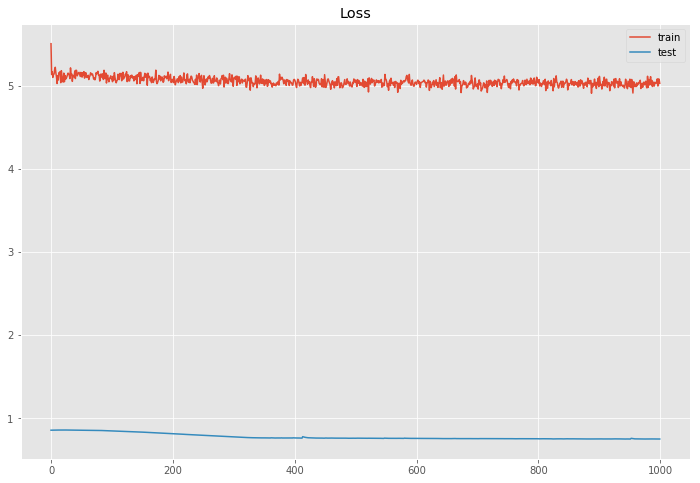

In [200]:
fig, ax = plt.subplots(figsize=(12,8))
ax.set_title('Loss')
ax.plot(history.history['loss'], label='train')
ax.plot(history.history['val_loss'], label='test')
ax.legend();

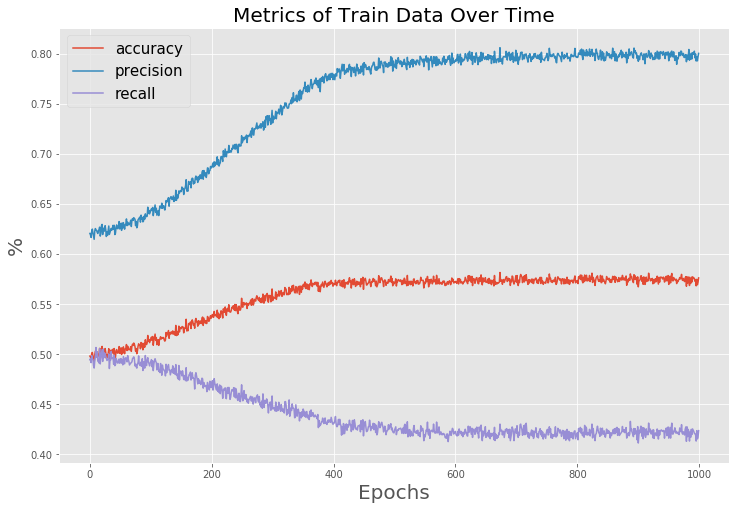

In [214]:
fig, ax = plt.subplots(figsize=(12,8))
ax.set_title('Metrics of Train Data Over Time', fontsize=20)
ax.plot(history.history['accuracy'], label='accuracy')
ax.plot(history.history['precision_32'], label='precision')
ax.plot(history.history['recall_32'], label='recall')
ax.set_xlabel('Epochs', fontsize=20)
ax.set_ylabel('%', fontsize=20)
ax.legend(loc='best', fontsize=15);
fig.savefig('img/metrics_nn.png')

In [215]:
scaler_test = StandardScaler()
X_test = scaler_train.fit_transform(X_test)
y_hat = model.predict(X_test)

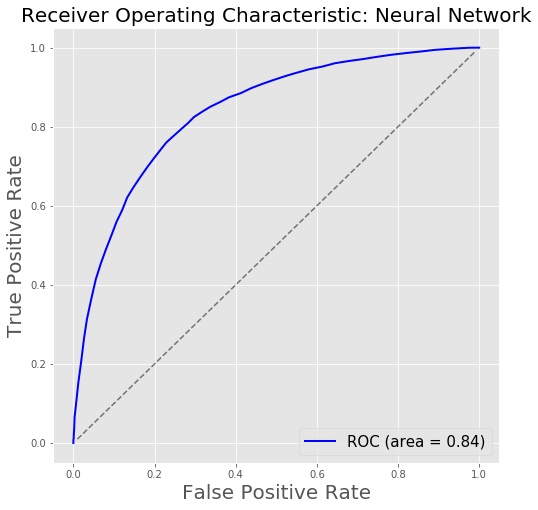

In [217]:
fig, ax = plt.subplots(figsize=(8,8))

ax, tpr, fpr, thresholds = plot_roc_curve(y_hat, y_test, ax, title='Neural Network')

fig.savefig('img/roc_nn.png')